# Lab 02: Economic Order Quantity (EOQ) with Price Breaks

**Objective:** Develop a program that determines the cost-minimizing order quantity for a product under a vendor's "all-units" quantity discount schedule. The program will read input data, compute feasible EOQs, evaluate the total annual cost for all candidate quantities, identify the optimal policy, and visualize the results.

This notebook will implement the required analysis, answer the discussion questions, and tackle the optional bonus challenges.

## 1. Setup and Data Input

First, we import the necessary libraries for data manipulation (`pandas`), numerical operations (`numpy`), and plotting (`matplotlib`, `seaborn`).

Then, we define the global parameters and the discount schedule based on the "Example Input Data" provided in the lab document. We use pandas DataFrames to simulate reading from an Excel file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Parameters (from Sheet "config") ---
annual_demand_D = 100  # units/year
ordering_cost_K = 45   # $/order
carrying_rate_i = 0.20 # fraction/year

print("--- Global Parameters ---")
print(f"Annual Demand (D): {annual_demand_D} units")
print(f"Ordering Cost (K): ${ordering_cost_K}")
print(f"Carrying Cost Rate (i): {carrying_rate_i*100}%")

# --- Discount Schedule (from Sheet "discounts") ---
discount_data = {
    'min_qty': [1, 50, 100],
    'max_qty': [49, 99, np.inf],
    'unit_price': [120.00, 115.00, 110.00]
}
discounts_df = pd.DataFrame(discount_data)

print("\n--- All-Units Discount Schedule ---")
display(discounts_df)

--- Global Parameters ---
Annual Demand (D): 100 units
Ordering Cost (K): $45
Carrying Cost Rate (i): 20.0%

--- All-Units Discount Schedule ---


,min_qty,max_qty,unit_price
0,1,49.0,120.0
1,50,99.0,115.0
2,100,inf,110.0


## 2. Core Logic: All-Units Discount Analysis

We implement the standard algorithm for finding the optimal order quantity with all-units discounts.

**Algorithm:**
1.  For each price tier `k` with unit cost `c_k`, calculate the nominal Economic Order Quantity (EOQ):
    $Q_k^* = \sqrt{\frac{2DK}{ic_k}}$
2.  Check if the calculated $Q_k^*$ is *feasible* (i.e., it falls within the quantity range for that price tier).
3.  If $Q_k^*$ is not feasible, the best candidate quantity for that tier is the minimum quantity required to get the price `c_k`.
4.  If $Q_k^*$ is feasible, it is the best candidate for that tier.
5.  Create a list of all candidate order quantities to evaluate. This list includes all feasible EOQs and all the minimum quantity price break points (except for the first tier's minimum).
6.  For each candidate quantity `Q`, calculate the Total Annual Cost (TAC) using the appropriate unit price `c(Q)`:
    $TAC(Q) = D \cdot c(Q) + \frac{D}{Q} \cdot K + \frac{Q}{2} \cdot i \cdot c(Q)$
    (Purchase Cost + Ordering Cost + Holding Cost)
7.  The optimal order quantity is the candidate `Q` that results in the lowest TAC.

In [2]:
def get_price(Q, schedule_df):
    """Finds the unit price for a given quantity Q from the discount schedule."""
    for index, row in schedule_df.iterrows():
        if Q >= row['min_qty'] and Q <= row['max_qty']:
            return row['unit_price']
    return None # Should not happen with a well-defined schedule

def calculate_tac(Q, D, K, i, schedule_df):
    """Calculates the Total Annual Cost for a given order quantity Q."""
    c = get_price(Q, schedule_df)
    if c is None:
        return np.inf

    purchase_cost = D * c
    ordering_cost = (D / Q) * K
    holding_cost = (Q / 2) * i * c

    return purchase_cost + ordering_cost + holding_cost

def analyze_eoq_discounts(D, K, i, schedule_df):
    """Performs the full EOQ analysis with all-units discounts."""
    results = []
    candidate_quantities = set()

    # Step 1-4: Calculate EOQ for each tier and determine feasibility
    for index, row in schedule_df.iterrows():
        c = row['unit_price']
        min_q, max_q = row['min_qty'], row['max_qty']

        # Calculate nominal EOQ for this tier's price
        nominal_eoq = np.sqrt((2 * D * K) / (i * c))

        # Check feasibility
        is_feasible = (nominal_eoq >= min_q) and (nominal_eoq <= max_q)

        # Determine the evaluated quantity for this tier
        if is_feasible:
            evaluated_q = nominal_eoq
        else:
            # If EOQ is too low, the best Q in this range is the minimum quantity
            evaluated_q = min_q

        candidate_quantities.add(evaluated_q)

        results.append({
            'Tier': index + 1,
            'Unit Price ($)': c,
            'Min Qty': int(min_q),
            'Max Qty': int(max_q) if max_q != np.inf else 'inf',
            'Nominal EOQ': round(nominal_eoq, 2),
            'Feasible?': is_feasible,
        })

    # Create the initial analysis table
    candidates_df = pd.DataFrame(results)

    # Step 5-7: Evaluate TAC for all candidate quantities and find the optimum
    evaluated_results = []
    for q in sorted(list(candidate_quantities)):
        tac = calculate_tac(q, D, K, i, schedule_df)
        evaluated_results.append({'Evaluated Q': q, 'TAC ($)': tac})

    final_candidates_df = pd.DataFrame(evaluated_results)
    final_candidates_df['Evaluated Q'] = final_candidates_df['Evaluated Q'].round(2)
    final_candidates_df['TAC ($)'] = final_candidates_df['TAC ($)'].round(2)

    # Find the optimal policy
    optimal_idx = final_candidates_df['TAC ($)'].idxmin()
    optimal_policy = final_candidates_df.loc[optimal_idx]

    # Merge tables for the final output format
    merged_df = candidates_df.copy()
    merged_df['Evaluated Q'] = [np.nan] * len(merged_df)
    merged_df['TAC ($)'] = [np.nan] * len(merged_df)

    eval_qs_from_logic = []
    for _, row in merged_df.iterrows():
        if row['Feasible?']:
            eval_qs_from_logic.append(row['Nominal EOQ'])
        else:
            eval_qs_from_logic.append(row['Min Qty'])

    merged_df['Evaluated Q'] = eval_qs_from_logic
    merged_df['TAC ($)'] = merged_df['Evaluated Q'].apply(lambda q: calculate_tac(q, D, K, i, schedule_df)).round(2)

    return merged_df, optimal_policy

# Run the analysis
candidates_table, optimal_policy = analyze_eoq_discounts(annual_demand_D, ordering_cost_K, carrying_rate_i, discounts_df)


## 3. Results and Visualization

### A. Candidates Table

The table below summarizes the analysis. For each price tier, it shows the calculated nominal EOQ and its feasibility. The "Evaluated Q" is the best candidate quantity from that tier (either the feasible EOQ or the tier's minimum quantity). The final column shows the Total Annual Cost (TAC) for each evaluated quantity.

In [3]:
display(candidates_table[['Tier', 'Unit Price ($)', 'Nominal EOQ', 'Feasible?', 'Evaluated Q', 'TAC ($)']])

,Tier,Unit Price ($),Nominal EOQ,Feasible?,Evaluated Q,TAC ($)
0,1,120.0,19.36,True,19.36,12464.76
1,2,115.0,19.78,False,50.00,12165.00
2,3,110.0,20.23,False,100.00,12145.00


### B. Cost Curve Plot

The following graph visualizes the Total Annual Cost (TAC) as a function of the order quantity (Q).
- Each colored curve represents the TAC for a specific price tier, plotted only within its valid quantity range.
- Vertical dashed lines mark the price break points where the unit cost changes.
- The red star marks the optimal order quantity and the corresponding minimum total annual cost.

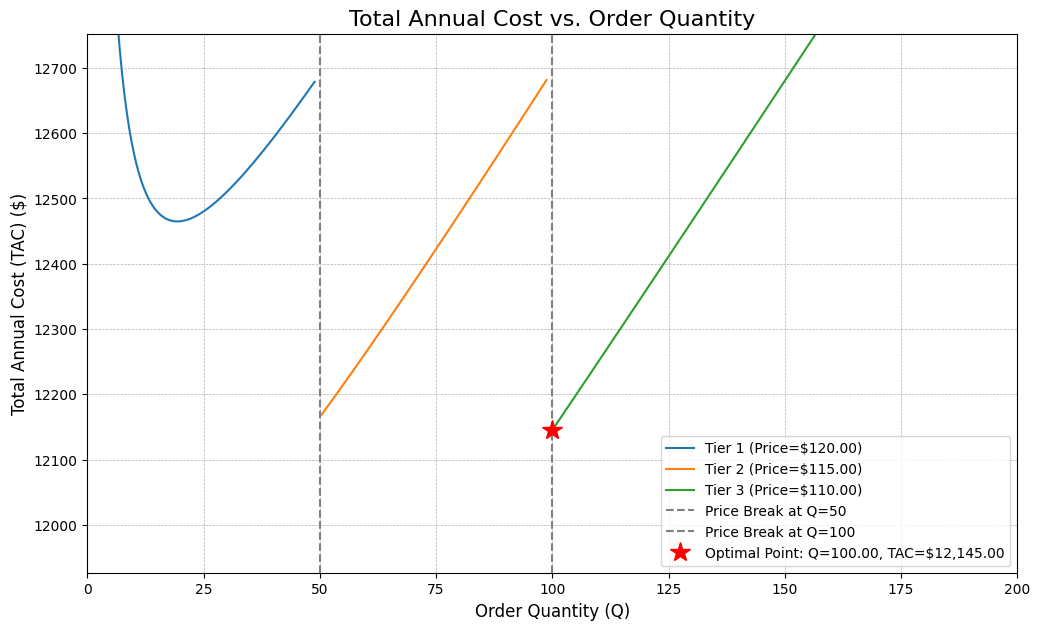

In [4]:
def plot_cost_curve(D, K, i, schedule_df, optimal_q, optimal_tac):
    plt.figure(figsize=(12, 7))

    # Define a wide range of Q values for plotting
    q_vals = np.linspace(1, 200, 400)

    # Plot TAC curve for each price tier
    for index, row in schedule_df.iterrows():
        c = row['unit_price']
        min_q, max_q = row['min_qty'], row['max_qty']

        # Filter Q values to the valid range for this tier
        tier_q_vals = q_vals[(q_vals >= min_q) & (q_vals <= max_q)]
        if len(tier_q_vals) == 0: continue

        purchase_cost = D * c
        ordering_cost = (D / tier_q_vals) * K
        holding_cost = (tier_q_vals / 2) * i * c
        tac_vals = purchase_cost + ordering_cost + holding_cost

        plt.plot(tier_q_vals, tac_vals, label=f'Tier {index+1} (Price=${c:.2f})')

    # Mark price breaks with vertical lines
    price_breaks = schedule_df['min_qty'].iloc[1:]
    for p_break in price_breaks:
        plt.axvline(x=p_break, color='grey', linestyle='--', label=f'Price Break at Q={p_break}')

    # Mark the optimal point
    plt.plot(optimal_q, optimal_tac, 'r*', markersize=15, label=f'Optimal Point: Q={optimal_q:.2f}, TAC=${optimal_tac:,.2f}')

    # Formatting
    plt.title('Total Annual Cost vs. Order Quantity', fontsize=16)
    plt.xlabel('Order Quantity (Q)', fontsize=12)
    plt.ylabel('Total Annual Cost (TAC) ($)', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=min(optimal_tac * 0.99, plt.ylim()[0]), top=optimal_tac * 1.05) # Zoom in on the relevant cost area
    plt.xlim(left=0, right=200)
    plt.show()

# Generate the plot
plot_cost_curve(annual_demand_D, ordering_cost_K, carrying_rate_i, discounts_df, optimal_policy['Evaluated Q'], optimal_policy['TAC ($)'])


### C. Recommendation

Based on the analysis, the optimal purchasing policy is to **order 100 units** at a time.

- **Optimal Order Quantity (Q*)**: 100 units
- **Price Tier**: 3 (Unit Price: $110.00)
- **Minimum Total Annual Cost (TAC)**: **$12,145.00**

**Justification:** Although the calculated EOQ for each price tier is small (~20 units), the cost savings from the lower unit price at the higher quantity breaks outweigh the increased inventory holding costs. Ordering 100 units achieves the lowest unit price of $110.00, resulting in the minimum possible total annual cost compared to any other order quantity.

## 4. Discussion Questions

### 1. How much cost savings (in $ and %) does the optimal discounted policy achieve compared to the no-discount case?

To determine the no-discount case, we assume we can only purchase at the highest price ($120.00). The optimal order quantity in this scenario would be the feasible EOQ for that tier.

In [5]:
# No-discount case uses the first tier's price and its feasible EOQ
no_discount_row = candidates_table.iloc[0]
no_discount_q = no_discount_row['Nominal EOQ']
no_discount_tac = calculate_tac(no_discount_q, annual_demand_D, ordering_cost_K, carrying_rate_i, discounts_df.iloc[[0]])

optimal_tac = optimal_policy['TAC ($)']
savings_dollars = no_discount_tac - optimal_tac
savings_percent = (savings_dollars / no_discount_tac) * 100

print(f"TAC for no-discount case (Q={no_discount_q:.2f}): ${no_discount_tac:,.2f}")
print(f"TAC for optimal discounted policy (Q={optimal_policy['Evaluated Q']:.0f}): ${optimal_tac:,.2f}")
print(f"\nCost Savings: ${savings_dollars:,.2f}")
print(f"Percentage Savings: {savings_percent:.2f}%")

TAC for no-discount case (Q=19.36): $12,464.76
TAC for optimal discounted policy (Q=100): $12,145.00

Cost Savings: $319.76
Percentage Savings: 2.57%


**Answer:** The optimal discounted policy achieves a cost saving of **$319.76**, which represents a **2.57%** reduction in total annual cost compared to ordering the standard EOQ without taking advantage of any discounts.

### 2. If the carrying-cost rate increases to 25%, does the optimal (Q) change? Why?

We re-run the analysis with the new carrying cost rate `i = 0.25`.

In [6]:
new_i = 0.25
new_candidates_table, new_optimal_policy = analyze_eoq_discounts(annual_demand_D, ordering_cost_K, new_i, discounts_df)

print(f"--- Analysis with Carrying Rate i = {new_i*100}% ---")
display(new_candidates_table[['Tier', 'Unit Price ($)', 'Nominal EOQ', 'Feasible?', 'Evaluated Q', 'TAC ($)']])

print("\n--- New Optimal Policy ---")
print(f"Optimal Q: {new_optimal_policy['Evaluated Q']}")
print(f"Minimum TAC: ${new_optimal_policy['TAC ($)']:,}")

--- Analysis with Carrying Rate i = 25.0% ---


,Tier,Unit Price ($),Nominal EOQ,Feasible?,Evaluated Q,TAC ($)
0,1,120.0,17.32,True,17.32,12519.62
1,2,115.0,17.69,False,50.00,12308.75
2,3,110.0,18.09,False,100.00,12420.00



--- New Optimal Policy ---
Optimal Q: 50.0
Minimum TAC: $12,308.75


**Answer:** **Yes, the optimal order quantity changes to 50 units.**

**Why:** A higher carrying cost rate (`i`) increases the expense of holding inventory. This makes ordering very large quantities (like 100) less attractive because the holding cost component of the TAC ($ (Q/2) \cdot i \cdot c $) becomes significantly larger. As shown in the new analysis, the TAC for ordering 50 units ($12,308.75) is now lower than the TAC for ordering 100 units ($12,420.00). The increased holding cost has shifted the economic balance in favor of a smaller order quantity.

### 3. Find the minimum demand (D) that makes a move to the next price tier worthwhile.

We want to find the demand `D` where the cost of ordering 100 units (at $110/unit) becomes equal to the cost of ordering 50 units (at $115/unit). Ordering 50 units is the best strategy in the middle tier, as its EOQ is always below 50. We set their TAC equations equal to each other and solve for `D`.

$TAC(Q=50, c=115) = TAC(Q=100, c=110)$

$D \cdot c_{50} + \frac{D}{50}K + \frac{50}{2}ic_{50} = D \cdot c_{100} + \frac{D}{100}K + \frac{100}{2}ic_{100}$

$D(c_{50} + \frac{K}{50}) + \frac{50}{2}ic_{50} = D(c_{100} + \frac{K}{100}) + \frac{100}{2}ic_{100}$

$D [(c_{50} - c_{100}) + K(\frac{1}{50} - \frac{1}{100})] = \frac{100}{2}ic_{100} - \frac{50}{2}ic_{50}$

In [7]:
# Parameters for the equation
K, i = ordering_cost_K, carrying_rate_i
c50, c100 = 115, 110
Q50, Q100 = 50, 100

# Left side of the equation (terms with D)
d_coefficient = (c50 - c100) + K * (1/Q50 - 1/Q100)

# Right side of the equation (constant terms)
constant_term = (Q100/2)*i*c100 - (Q50/2)*i*c50

indifference_demand_D = constant_term / d_coefficient

print(f"The minimum annual demand (D) to justify ordering 100 units is: {indifference_demand_D:.2f} units.")

The minimum annual demand (D) to justify ordering 100 units is: 96.33 units.


**Answer:** The minimum annual demand required to make the move from ordering 50 units to 100 units worthwhile is approximately **96.33 units**. At any demand higher than this, the savings from the $110 unit price will overcome the higher holding costs, making Q=100 the cheaper option.

### 4. Summarize the managerial lesson: when do price breaks justify larger lots?

**Answer:** Price breaks justify ordering larger lot sizes when the **total cost reduction from the lower purchase price outweighs the increase in inventory holding costs**.

A manager should not blindly accept a quantity discount. They must perform a Total Annual Cost (TAC) analysis that includes three key components: total purchase cost, total ordering cost, and total holding cost. A larger order quantity will always:
1.  **Decrease** the annual total purchase cost (if a lower price is achieved).
2.  **Decrease** the annual total ordering cost (since fewer orders are placed).
3.  **Increase** the annual total inventory holding cost (due to higher average inventory).

The decision is justified only if the sum of savings from (1) and (2) is greater than the additional cost from (3). This trade-off is also sensitive to factors like the carrying cost rate (`i`) and annual demand (`D`), as demonstrated in the previous questions.

## 5. Bonus Challenges

### Bonus 5.1: Incremental Discounts

Under an **incremental discount** schedule, the price break applies only to the units *within* that tier, not to all units purchased. We need a new TAC function to handle this logic.

In [8]:
def calculate_incremental_purchase_cost(Q, schedule_df):
    """Calculates the total purchase cost for an order of size Q under an incremental schedule."""
    cost = 0
    remaining_q = Q

    for index, row in schedule_df.iterrows():
        min_q, max_q, price = row['min_qty'], row['max_qty'], row['unit_price']

        if remaining_q <= 0:
            break

        # Quantity in this tier
        tier_qty = min(remaining_q, max_q - min_q + 1)
        cost += tier_qty * price
        remaining_q -= tier_qty

    return cost

def calculate_incremental_tac(Q, D, K, i, schedule_df):
    """Calculates the TAC for an order Q under an incremental discount schedule."""
    # Total annual purchase cost is D * (average cost per unit)
    avg_unit_cost = calculate_incremental_purchase_cost(Q, schedule_df) / Q
    annual_purchase_cost = D * avg_unit_cost

    # Ordering cost is the same
    ordering_cost = (D / Q) * K

    # Holding cost is based on the value of the inventory held
    holding_cost = (Q / 2) * i * avg_unit_cost

    return annual_purchase_cost + ordering_cost + holding_cost

# To find the optimal Q, we can't just plug into the EOQ formula because c is a function of Q.
# A common approach is to search over a range of Q or check breakpoints.
# Here we will evaluate the TAC at the same candidate quantities from the all-units case for comparison.

print("--- TAC Evaluation with Incremental Discounts ---")
incremental_results = []
candidate_qs = sorted(list(candidates_table['Evaluated Q']))

for q in candidate_qs:
    tac = calculate_incremental_tac(q, annual_demand_D, ordering_cost_K, carrying_rate_i, discounts_df)
    incremental_results.append({'Q': round(q,2), 'Incremental TAC ($)': round(tac, 2)})

incremental_df = pd.DataFrame(incremental_results)
optimal_incremental = incremental_df.loc[incremental_df['Incremental TAC ($)'].idxmin()]
display(incremental_df)

print("\nOptimal Policy under Incremental Discounts:")
print(f"Order Quantity: {optimal_incremental['Q']}")
print(f"Minimum TAC: ${optimal_incremental['Incremental TAC ($)']}")

--- TAC Evaluation with Incremental Discounts ---


,Q,Incremental TAC ($)
0,19.36,12464.76
1,50.00,12679.50
2,100.00,12959.00



Optimal Policy under Incremental Discounts:
Order Quantity: 19.36
Minimum TAC: $12464.76


### Bonus 5.2: Heatmap Visualization

This heatmap shows the optimal order quantity (Q*) for a range of Annual Demand (D) and Carrying Cost Rates (i). This provides a powerful visual tool for understanding how the optimal policy shifts with changing business conditions.

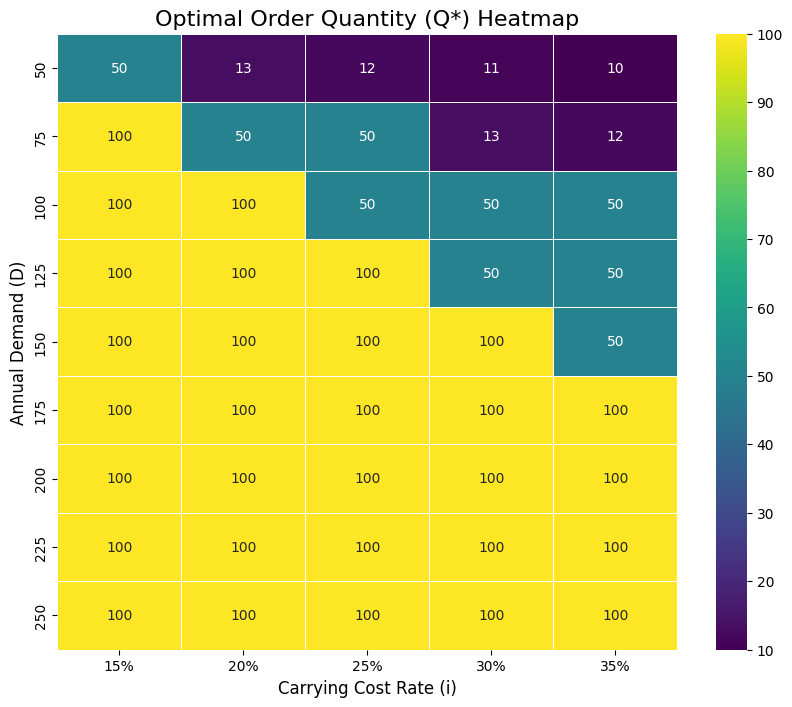

In [9]:
def find_optimal_q(D, K, i, schedule_df):
    """A wrapper function to return only the optimal Q."""
    _, optimal_policy = analyze_eoq_discounts(D, K, i, schedule_df)
    return optimal_policy['Evaluated Q']

# Define ranges for D and i
d_range = np.arange(50, 251, 25)  # Demand from 50 to 250
i_range = np.arange(0.15, 0.36, 0.05) # Carrying rate from 15% to 35%

# Create an empty dataframe to store heatmap data
heatmap_data = pd.DataFrame(index=d_range, columns=[f"{r*100:.0f}%" for r in i_range])

# Populate the dataframe with optimal Q values
for d_val in d_range:
    for i_val in i_range:
        opt_q = find_optimal_q(d_val, ordering_cost_K, i_val, discounts_df)
        heatmap_data.loc[d_val, f"{i_val*100:.0f}%"] = opt_q

heatmap_data = heatmap_data.astype(int)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="viridis", linewidths=.5)
plt.title('Optimal Order Quantity (Q*) Heatmap', fontsize=16)
plt.xlabel('Carrying Cost Rate (i)', fontsize=12)
plt.ylabel('Annual Demand (D)', fontsize=12)
plt.show()

### Bonus 5.3: Reorder Point (ROP) Calculation

The Reorder Point (ROP) is the inventory level at which a new order should be placed. It is calculated to cover demand during the lead time.

$ROP = (Daily\ Demand) \times (Lead\ Time\ in\ Days)$

We will assume the optional parameters for this calculation.

In [10]:
def calculate_rop(D, lead_time_days, working_days_per_year):
    """Calculates the Reorder Point (ROP)."""
    daily_demand = D / working_days_per_year
    rop = daily_demand * lead_time_days
    return rop, daily_demand

# Assumed parameters for demonstration
lead_time_L = 10         # days
working_days = 250     # days/year

reorder_point, daily_demand = calculate_rop(annual_demand_D, lead_time_L, working_days)

print("--- Reorder Point Calculation ---")
print(f"Assumed Lead Time (L): {lead_time_L} days")
print(f"Assumed Working Days/Year: {working_days}")
print(f"Calculated Daily Demand: {daily_demand:.2f} units/day")
print(f"\nReorder Point (ROP): {reorder_point:.2f} units")
print("\nThis means an order for 100 units should be placed when the inventory on hand drops to 4 units.")

--- Reorder Point Calculation ---
Assumed Lead Time (L): 10 days
Assumed Working Days/Year: 250
Calculated Daily Demand: 0.40 units/day

Reorder Point (ROP): 4.00 units

This means an order for 100 units should be placed when the inventory on hand drops to 4 units.
